In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset/dataset.csv
/kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Raw Data/Raw/512Glioma/glioma (123).jpg
/kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Raw Data/Raw/512Glioma/glioma (10).jpg
/kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Raw Data/Raw/512Glioma/glioma (179).jpg
/kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Raw Data/Raw/512Glioma/glioma (352).jpg
/kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Raw Data/Raw/512Glioma/glioma (130).j

In [2]:
import os
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torchvision.models import AlexNet_Weights
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset using ImageFolder
dataset_root = "/kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Augmented Data/Augmented"  
dataset = ImageFolder(root=dataset_root, transform=transform)

# First split: train (70%) and temp (30%)
train_indices, temp_indices = train_test_split(
    range(len(dataset)),
    test_size=0.3,
    stratify=dataset.targets,
    random_state=42
)

# Second split: temp into validation (10% of total) and test (20% of total)
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=2/3,  # 2/3 of 30% is 20% of the total dataset
    stratify=[dataset.targets[i] for i in temp_indices],
    random_state=42
)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Print class distribution in the full dataset
print("Full dataset class distribution:", Counter(dataset.targets))

# Print class distribution in the training set
train_labels = [dataset.targets[i] for i in train_indices]
print("Training set class distribution:", Counter(train_labels))

# Print class distribution in the validation set
val_labels = [dataset.targets[i] for i in val_indices]
print("Validation set class distribution:", Counter(val_labels))

# Print class distribution in the test set
test_labels = [dataset.targets[i] for i in test_indices]
print("Test set class distribution:", Counter(test_labels))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Full dataset class distribution: Counter({0: 1501, 1: 1501, 2: 1501, 3: 1501})
Training set class distribution: Counter({1: 1051, 3: 1051, 0: 1050, 2: 1050})
Validation set class distribution: Counter({1: 150, 2: 150, 0: 150, 3: 150})
Test set class distribution: Counter({2: 301, 0: 301, 1: 300, 3: 300})


In [4]:
# Define a function for Kaiming weight initialization
def initialize_weights(model):
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        self.model = nn.Sequential(
            # First convolutional block
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),

            # Second convolutional block
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),

            # Third convolutional block
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),

            # Flattening the tensor
            nn.Flatten(),

            # Fully connected layers
            nn.Linear(in_features=128 * 28 * 28, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=4),
        )

    def forward(self, x):
        return self.model(x)

# Example usage
model = CustomCNN()

# Apply Kaiming initialization
initialize_weights(model)

# Print the model to verify
print(model)

CustomCNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (

In [5]:
# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = CustomCNN().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)

Using device: cuda


Epoch 1/50 - Validation: 100%|██████████| 75/75 [00:05<00:00, 12.87it/s]


Epoch 1/50, Train Loss: 1.5697, Train Acc: 40.15%, Val Loss: 1.2455, Val Acc: 39.83%


Epoch 2/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 23.83it/s]


Epoch 2/50, Train Loss: 1.1638, Train Acc: 45.57%, Val Loss: 1.2885, Val Acc: 38.83%


Epoch 3/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 22.16it/s]


Epoch 3/50, Train Loss: 1.0995, Train Acc: 50.81%, Val Loss: 1.1190, Val Acc: 45.67%


Epoch 4/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 24.16it/s]


Epoch 4/50, Train Loss: 1.0220, Train Acc: 55.02%, Val Loss: 1.2085, Val Acc: 41.67%


Epoch 5/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 23.98it/s]


Epoch 5/50, Train Loss: 0.9169, Train Acc: 61.07%, Val Loss: 1.4918, Val Acc: 42.83%


Epoch 6/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 24.74it/s]


Epoch 6/50, Train Loss: 0.8644, Train Acc: 62.66%, Val Loss: 1.0189, Val Acc: 51.67%


Epoch 7/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 23.77it/s]


Epoch 7/50, Train Loss: 0.8244, Train Acc: 65.16%, Val Loss: 0.9017, Val Acc: 58.33%


Epoch 8/50 - Validation: 100%|██████████| 75/75 [00:02<00:00, 25.62it/s]


Epoch 8/50, Train Loss: 0.7645, Train Acc: 68.06%, Val Loss: 0.8855, Val Acc: 55.33%


Epoch 9/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 23.89it/s]


Epoch 9/50, Train Loss: 0.7247, Train Acc: 68.75%, Val Loss: 0.9006, Val Acc: 60.33%


Epoch 10/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 24.92it/s]


Epoch 10/50, Train Loss: 0.7200, Train Acc: 70.01%, Val Loss: 1.3014, Val Acc: 49.17%


Epoch 11/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 24.17it/s]


Epoch 11/50, Train Loss: 0.6895, Train Acc: 70.94%, Val Loss: 1.3065, Val Acc: 51.50%


Epoch 12/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 24.33it/s]


Epoch 12/50, Train Loss: 0.6869, Train Acc: 70.70%, Val Loss: 0.7744, Val Acc: 64.17%


Epoch 13/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 23.89it/s]


Epoch 13/50, Train Loss: 0.6429, Train Acc: 72.97%, Val Loss: 0.6243, Val Acc: 72.00%


Epoch 14/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 23.90it/s]


Epoch 14/50, Train Loss: 0.6289, Train Acc: 74.08%, Val Loss: 0.7078, Val Acc: 69.00%


Epoch 15/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 22.25it/s]


Epoch 15/50, Train Loss: 0.6047, Train Acc: 74.63%, Val Loss: 0.7190, Val Acc: 67.17%


Epoch 16/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 23.59it/s]


Epoch 16/50, Train Loss: 0.6078, Train Acc: 75.46%, Val Loss: 0.6896, Val Acc: 70.50%


Epoch 17/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 24.48it/s]


Epoch 17/50, Train Loss: 0.5893, Train Acc: 75.68%, Val Loss: 0.7029, Val Acc: 68.83%


Epoch 18/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 22.34it/s]


Epoch 18/50, Train Loss: 0.5682, Train Acc: 76.56%, Val Loss: 0.8596, Val Acc: 63.83%


Epoch 19/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 23.49it/s]


Epoch 19/50, Train Loss: 0.5410, Train Acc: 77.80%, Val Loss: 0.6804, Val Acc: 71.67%


Epoch 20/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 23.88it/s]


Epoch 20/50, Train Loss: 0.5327, Train Acc: 77.92%, Val Loss: 0.8997, Val Acc: 63.00%


Epoch 21/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 23.56it/s]


Epoch 21/50, Train Loss: 0.5184, Train Acc: 79.03%, Val Loss: 0.6265, Val Acc: 73.67%


Epoch 22/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 22.74it/s]


Epoch 22/50, Train Loss: 0.5044, Train Acc: 79.06%, Val Loss: 0.7977, Val Acc: 65.83%


Epoch 23/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 23.38it/s]


Epoch 23/50, Train Loss: 0.5013, Train Acc: 78.89%, Val Loss: 0.4996, Val Acc: 80.00%


Epoch 24/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 21.67it/s]


Epoch 24/50, Train Loss: 0.4857, Train Acc: 80.53%, Val Loss: 0.5169, Val Acc: 75.50%


Epoch 25/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 23.70it/s]


Epoch 25/50, Train Loss: 0.4873, Train Acc: 80.18%, Val Loss: 0.4767, Val Acc: 79.17%


Epoch 26/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 22.94it/s]


Epoch 26/50, Train Loss: 0.4627, Train Acc: 80.77%, Val Loss: 0.8556, Val Acc: 65.00%


Epoch 27/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 23.85it/s]


Epoch 27/50, Train Loss: 0.4405, Train Acc: 82.53%, Val Loss: 0.8955, Val Acc: 65.67%


Epoch 28/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 23.22it/s]


Epoch 28/50, Train Loss: 0.4546, Train Acc: 81.18%, Val Loss: 0.7149, Val Acc: 69.50%


Epoch 29/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 24.16it/s]


Epoch 29/50, Train Loss: 0.4366, Train Acc: 82.34%, Val Loss: 0.4867, Val Acc: 80.00%


Epoch 30/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 24.27it/s]


Epoch 30/50, Train Loss: 0.4531, Train Acc: 81.63%, Val Loss: 0.4558, Val Acc: 80.50%


Epoch 31/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 23.78it/s]


Epoch 31/50, Train Loss: 0.4239, Train Acc: 83.06%, Val Loss: 0.6321, Val Acc: 74.83%


Epoch 32/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 24.08it/s]


Epoch 32/50, Train Loss: 0.4145, Train Acc: 84.03%, Val Loss: 0.4465, Val Acc: 79.83%


Epoch 33/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 24.18it/s]


Epoch 33/50, Train Loss: 0.4165, Train Acc: 83.65%, Val Loss: 0.5488, Val Acc: 76.83%


Epoch 34/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 22.75it/s]


Epoch 34/50, Train Loss: 0.4045, Train Acc: 83.86%, Val Loss: 0.6114, Val Acc: 74.33%


Epoch 35/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 23.45it/s]


Epoch 35/50, Train Loss: 0.3781, Train Acc: 85.10%, Val Loss: 0.4933, Val Acc: 78.83%


Epoch 36/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 22.67it/s]


Epoch 36/50, Train Loss: 0.3957, Train Acc: 84.15%, Val Loss: 0.6077, Val Acc: 75.83%


Epoch 37/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 23.53it/s]


Epoch 37/50, Train Loss: 0.3860, Train Acc: 84.89%, Val Loss: 0.5241, Val Acc: 77.33%


Epoch 38/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 23.93it/s]


Epoch 38/50, Train Loss: 0.3737, Train Acc: 85.20%, Val Loss: 0.4493, Val Acc: 80.00%


Epoch 39/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 24.00it/s]


Epoch 39/50, Train Loss: 0.3526, Train Acc: 86.53%, Val Loss: 0.4659, Val Acc: 80.67%


Epoch 40/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 24.33it/s]


Epoch 40/50, Train Loss: 0.3550, Train Acc: 85.96%, Val Loss: 0.6456, Val Acc: 74.17%


Epoch 41/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 24.58it/s]


Epoch 41/50, Train Loss: 0.3414, Train Acc: 86.46%, Val Loss: 0.4130, Val Acc: 83.33%


Epoch 42/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 24.02it/s]


Epoch 42/50, Train Loss: 0.3471, Train Acc: 86.44%, Val Loss: 0.6011, Val Acc: 78.33%


Epoch 43/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 22.96it/s]


Epoch 43/50, Train Loss: 0.3439, Train Acc: 86.48%, Val Loss: 0.4295, Val Acc: 82.00%


Epoch 44/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 22.34it/s]


Epoch 44/50, Train Loss: 0.3404, Train Acc: 86.70%, Val Loss: 0.6141, Val Acc: 76.33%


Epoch 45/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 22.95it/s]


Epoch 45/50, Train Loss: 0.3569, Train Acc: 85.89%, Val Loss: 1.0316, Val Acc: 64.17%


Epoch 46/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 23.45it/s]


Epoch 46/50, Train Loss: 0.3172, Train Acc: 87.39%, Val Loss: 0.5740, Val Acc: 77.50%


Epoch 47/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 23.54it/s]


Epoch 47/50, Train Loss: 0.3325, Train Acc: 86.84%, Val Loss: 0.5365, Val Acc: 80.33%


Epoch 48/50 - Validation: 100%|██████████| 75/75 [00:02<00:00, 25.33it/s]


Epoch 48/50, Train Loss: 0.3176, Train Acc: 87.60%, Val Loss: 0.4950, Val Acc: 81.67%


Epoch 49/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 22.47it/s]


Epoch 49/50, Train Loss: 0.3134, Train Acc: 88.15%, Val Loss: 0.7534, Val Acc: 72.50%


Epoch 50/50 - Validation: 100%|██████████| 75/75 [00:03<00:00, 24.18it/s]


Epoch 50/50, Train Loss: 0.3090, Train Acc: 87.36%, Val Loss: 0.4114, Val Acc: 84.33%
Training complete!


Testing: 100%|██████████| 151/151 [00:12<00:00, 11.62it/s]


Test Loss: 0.4549, Test Accuracy: 82.03%

Confusion Matrix:
                     Pred: 512Glioma  Pred: 512Meningioma  Pred: 512Normal  \
True: 512Glioma                  215                   45                6   
True: 512Meningioma               44                  219               32   
True: 512Normal                    4                   30              264   
True: 512Pituitary                 9                    0                3   

                     Pred: 512Pituitary  
True: 512Glioma                      35  
True: 512Meningioma                   5  
True: 512Normal                       3  
True: 512Pituitary                  288  

Classification Report:
               precision    recall  f1-score   support

    512Glioma       0.79      0.71      0.75       301
512Meningioma       0.74      0.73      0.74       300
    512Normal       0.87      0.88      0.87       301
 512Pituitary       0.87      0.96      0.91       300

     accuracy                         

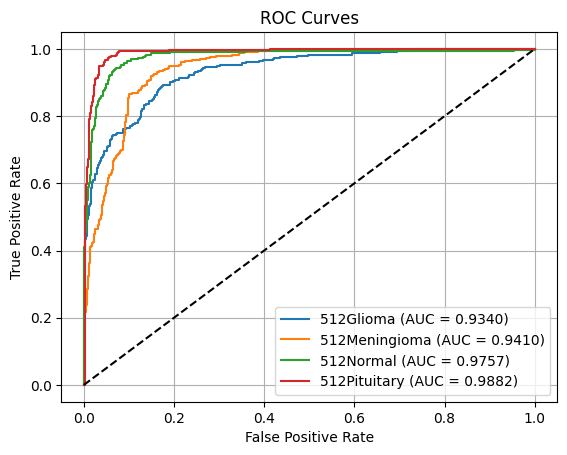

In [6]:
# Training loop with early stopping
num_epochs = 50
patience = 8  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    # Training phase
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total * 100

    # Validation phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct / total * 100

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # # Early stopping logic
    # if val_loss < best_val_loss:
    #     print("Validation loss improved.")
    #     best_val_loss = val_loss
    #     epochs_without_improvement = 0
    #     # torch.save(model.state_dict(), "best_model.pth")  # Save the best model
    # else:
    #     print("Validation loss did not improve.")
    #     epochs_without_improvement += 1
    #     if epochs_without_improvement >= patience:
    #         print(f"Early stopping triggered after {epoch+1} epochs.")
    #         break

print("Training complete!")

# Load the best model before testing
# model.load_state_dict(torch.load("best_model.pth"))

# Evaluate on test set
model.eval()
test_loss, correct, total = 0.0, 0, 0
all_labels = []
all_predictions = []
all_probabilities = []

# Reverse the class_to_idx mapping to get idx_to_class
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        probabilities = torch.nn.functional.softmax(outputs, dim=1)  # Get probabilities
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Collect all labels, predictions, and probabilities for metrics
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = correct / total * 100

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
# Convert numeric predictions and labels to class names
all_labels_names = [idx_to_class[label] for label in all_labels]
all_predictions_names = [idx_to_class[pred] for pred in all_predictions]

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Create a DataFrame for better visualization
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=[f"True: {label}" for label in dataset.classes],  # True labels
    columns=[f"Pred: {label}" for label in dataset.classes]  # Predicted labels
)

# Print metrics
print("\nConfusion Matrix:")
print(conf_matrix_df)

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=dataset.classes))

# Calculate ROC and AUC for each class
print("\nROC and AUC Metrics:")
for i, class_name in enumerate(dataset.classes):
    true_binary = [1 if label == i else 0 for label in all_labels]  # Binary labels for the current class
    probabilities = [prob[i] for prob in all_probabilities]  # Probabilities for the current class

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(true_binary, probabilities)
    auc_score = roc_auc_score(true_binary, probabilities)
    print(f"Class '{class_name}': AUC = {auc_score:.4f}")

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc_score:.4f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [7]:
conf_matrix_df

,Pred: 512Glioma,Pred: 512Meningioma,Pred: 512Normal,Pred: 512Pituitary
True: 512Glioma,215,45,6,35
True: 512Meningioma,44,219,32,5
True: 512Normal,4,30,264,3
True: 512Pituitary,9,0,3,288
